In [2]:
import pandas as pd
import xml.etree.ElementTree as ET
from google.colab import files
import gzip


def lhe_to_dataframe(lhe_filename):

  # =============================================================
  # Leitor de arquivos .lhe e conversor para pandas.DataFrame
  # =============================================================
  # -------------------------------------------------------------
  # 1. Ler arquivo .lhe usando XML parser
  # -------------------------------------------------------------
  with gzip.open(lhe_filename, "rt") as f:
      content = f.read()

  # Arquivos LHE podem ter headers antes do XML, então ajustamos:
  content = content[content.find("<LesHouchesEvents"):]
  root = ET.fromstring(content)

  # -------------------------------------------------------------
  # 2. Extrair eventos
  # -------------------------------------------------------------
  events_data = []
  event_id = 0
  for event in root.findall("event"):

      event_id += 1  # cada <event> é um novo evento

      lines = event.text.strip().split("\n")

      # Primeira linha contém metadados do evento
      header = lines[0].split()
      n_particles = int(header[0])  # número de partículas

      # Linhas seguintes = partículas
      particle_lines = lines[1 : 1 + n_particles]

      for p in particle_lines:
          vals = p.split()

          # Formato padrão LHE possui 13 colunas:
          # 0: ID, 1: status, 2: mother1, 3: mother2,
          # 4: color1, 5: color2,
          # 6-8: px, py, pz,
          # 9: E, 10: mass,
          # 11: lifetime, 12: spin

          particle_dict = {
              "event_id":   event_id,
              "pdg_id":     int(vals[0]),
              "status":     int(vals[1]),
              "mother1":    int(vals[2]),
              "mother2":    int(vals[3]),
              "color1":     int(vals[4]),
              "color2":     int(vals[5]),
              "px":         float(vals[6]),
              "py":         float(vals[7]),
              "pz":         float(vals[8]),
              "E":          float(vals[9]),
              "mass":       float(vals[10]),
              "lifetime":   float(vals[11]),
              "spin":       float(vals[12]),
          }

          events_data.append(particle_dict)

  # -------------------------------------------------------------
  # 3. Transformar em DataFrame
  # -------------------------------------------------------------
  df = pd.DataFrame(events_data)

  print("DataFrame carregado com sucesso!")
  return df


In [3]:
!git clone https://github.com/FIS01214/lucas-lucas

# -------------------------------------------------------------
# Carregar arquivos .lhe do computador
# -------------------------------------------------------------

sinal_lhe_filename = "/content/lucas-lucas/data/sinal.lhe.gz"
fundo_lhe_filename = "/content/lucas-lucas/data/fundo.lhe.gz"


sinal_df=lhe_to_dataframe(sinal_lhe_filename)

fundo_df = lhe_to_dataframe(fundo_lhe_filename)

#


# # -------------------------------------------------------------
# #Salvar se quiser exportar
# # -------------------------------------------------------------
# # df.to_csv("lhe_to_dataframe.csv", index=False)
# # print("\nArquivo 'lhe_to_dataframe.csv' gerado!")
# # files.download("lhe_to_dataframe.csv")


Cloning into 'lucas-lucas'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 35 (delta 12), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 2.51 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (12/12), done.
DataFrame carregado com sucesso!
DataFrame carregado com sucesso!


In [4]:
#Número de Eventos(abri o arquivo .lhe e verifiquei na mão que é 10000)
print("Número de eventos do sinal: ", sinal_df['event_id'].nunique())
print("Número de eventos do fundo: ", fundo_df['event_id'].nunique())

Número de eventos do sinal:  10000
Número de eventos do fundo:  10000


In [5]:
# ========================================================
# OBJETIVO 1: Tabela das partículas por status
# ========================================================

# Mapeamento básico PDG → nome de partícula

pdg_names = {
    1: "d", -1: "d̄",
    2: "u", -2: "ū",
    3: "s", -3: "s̄",
    4: "c", -4: "c̄",
    5: "b", -5: "b̄",
    6: "t", -6: "t̄",
    11: "e⁻", -11: "e⁺",
    12: "ν_e", -12: "ν̄_e",
    13: "μ⁻", -13: "μ⁺",
    14: "ν_μ", -14: "ν̄_μ",
    15: "τ⁻", -15: "τ⁺",
    16: "ν_τ", -16: "ν̄_τ",
    21: "g",
    22: "γ",
    23: "Z",
    24: "W⁺", -24: "W⁻",
    25: "H"
}

def name(pdg):
    return pdg_names.get(pdg, str(pdg))

# Adiciona uma coluna com o nome das partículas
sinal_df["particle"] = sinal_df["pdg_id"].apply(name)

fundo_df["particle"] = fundo_df["pdg_id"].apply(name)

# Tabela agrupada por status
tabela_status_sinal = sinal_df.groupby(["status", "particle"]).size().reset_index(name="count")
tabela_status_fundo = fundo_df.groupby(["status", "particle"]).size().reset_index(name="count")

print("=== Tabela de Partículas por Status (Arquivo Sinal) ===")
display(tabela_status_sinal)

print("\n=== Tabela de Partículas por Status (Arquivo Fundo) ===")
display(tabela_status_fundo)



=== Tabela de Partículas por Status (Arquivo Sinal) ===


,status,particle,count
0,-1,c,861
1,-1,c̄,861
2,-1,d,4151
3,-1,d̄,4151
4,-1,s,1374
5,-1,s̄,1374
6,-1,u,3614
7,-1,ū,3614
8,1,e⁺,10000
9,1,e⁻,10000



=== Tabela de Partículas por Status (Arquivo Fundo) ===


,status,particle,count
0,-1,c,1057
1,-1,c̄,1057
2,-1,d,3492
3,-1,d̄,3492
4,-1,s,1140
5,-1,s̄,1140
6,-1,u,4311
7,-1,ū,4311
8,1,e⁺,10000
9,1,e⁻,10000


Processo de sinal: qq̅ ⟶ Z ⟶ e⁺ e⁻

Processo de fundo: qq̅ ⟶ γ ⟶ e⁺ e⁻

Eventos únicos representados (sinal): 10000
Eventos únicos representados (fundo):  10000
Partículas finais usadas (sinal): 20000
Partículas finais usadas (fundo):  20000


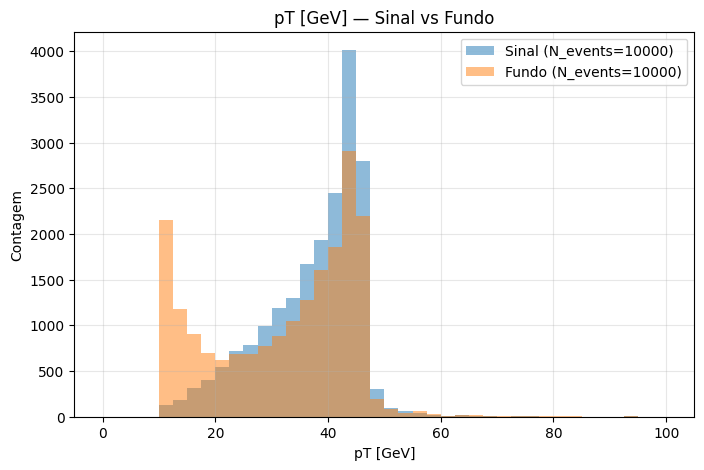

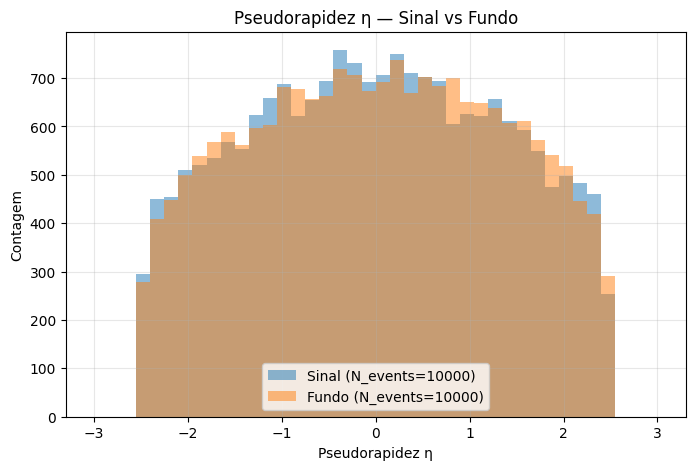

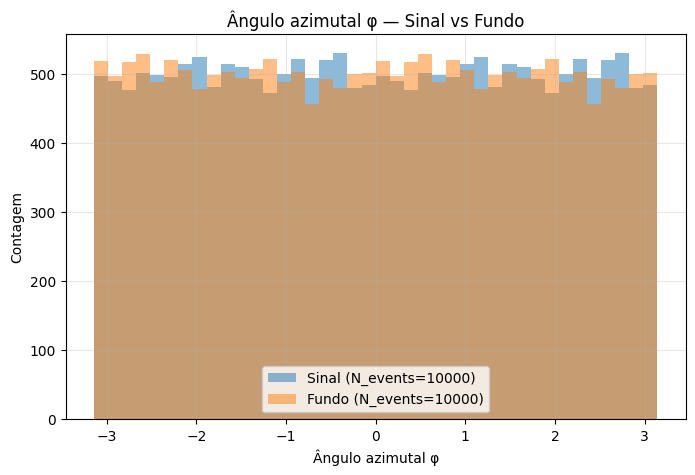

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Checagens / cópias (não alterar os originais) ---
sinal = sinal_df.copy()
fundo = fundo_df.copy()

# --- Calcular pt, eta, phi se não existirem ---
def ensure_kinematics(df):
    # exige px, py, pz (criado no parser LHE)
    if "px" not in df.columns or "py" not in df.columns or "pz" not in df.columns:
        raise ValueError("DataFrame precisa das colunas 'px','py','pz' para calcular cinemática.")

    if "pt" not in df.columns:
        df["pt"] = np.sqrt(df["px"]**2 + df["py"]**2)
    if "phi" not in df.columns:
        df["phi"] = np.arctan2(df["py"], df["px"])  # já em [-pi, pi]
    if "eta" not in df.columns:
        # eta = asinh(pz / pt) is numerically stable for pt>0
        # for pt == 0, set to +/- inf depending on sign(pz)
        pt = df["pt"].values
        pz = df["pz"].values
        eta = np.empty(len(df))
        with np.errstate(divide='ignore', invalid='ignore'):
            # safe for pt>0
            eta = np.arcsinh(pz / pt)
        # where pt==0 set sign(pz)*inf
        zero_mask = (pt == 0)
        if zero_mask.any():
            eta[zero_mask] = np.sign(pz[zero_mask]) * np.inf
        df["eta"] = eta
    return df

sinal = ensure_kinematics(sinal)
fundo = ensure_kinematics(fundo)

# --- Selecionar partículas finais (status = 1) e remover neutrinos ---
neutrinos = {12, 14, 16}
final_sinal = sinal[sinal["status"] == 1].copy()
final_fundo = fundo[fundo["status"] == 1].copy()

# remover neutrinos (baseado em coluna 'pdg_id' ou 'pdg')
pdg_col = None
for c in ("pdg_id", "pdg", "id"):
    if c in final_sinal.columns:
        pdg_col = c
        break
if pdg_col is None:
    raise ValueError("Nenhuma coluna PDG encontrada: aguarda 'pdg_id' ou 'pdg' no DataFrame.")

final_sinal = final_sinal[~final_sinal[pdg_col].abs().isin(neutrinos)]
final_fundo = final_fundo[~final_fundo[pdg_col].abs().isin(neutrinos)]

# --- Remover entradas com eta infinito (caso ocorram) para os histogramas ---
final_sinal = final_sinal.replace([np.inf, -np.inf], np.nan).dropna(subset=["eta"])
final_fundo = final_fundo.replace([np.inf, -np.inf], np.nan).dropna(subset=["eta"])

# --- Número de eventos representados em cada histograma ---
eventos_sinal = final_sinal["event_id"].nunique() if "event_id" in final_sinal.columns else "event_id não encontrado"
eventos_fundo = final_fundo["event_id"].nunique() if "event_id" in final_fundo.columns else "event_id não encontrado"

print(f"Eventos únicos representados (sinal): {eventos_sinal}")
print(f"Eventos únicos representados (fundo):  {eventos_fundo}")
print(f"Partículas finais usadas (sinal): {len(final_sinal)}")
print(f"Partículas finais usadas (fundo):  {len(final_fundo)}")

# --- Função para plotar comparação sinal vs fundo ---
def plot_compare(df_sinal, df_fundo,eventos_sinal, eventos_fundo,var, xlabel, bins, xrng):
    plt.figure(figsize=(8,5))
    # histograma do sinal
    plt.hist(df_sinal[var], bins=bins, range=xrng, alpha=0.5, density=False,
             label=f"Sinal (N_events={eventos_sinal})", histtype="stepfilled")
    # histograma do fundo
    plt.hist(df_fundo[var], bins=bins, range=xrng, alpha=0.5, density=False,
             label=f"Fundo (N_events={eventos_fundo})", histtype="stepfilled")
    plt.xlabel(xlabel)
    plt.ylabel("Contagem")
    plt.title(f"{xlabel} — Sinal vs Fundo")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- Histogramas solicitados ---
# pT de 0 a 100 GeV
plot_compare(final_sinal, final_fundo, eventos_sinal, eventos_fundo, "pt", "pT [GeV]", bins=40, xrng=(0,100))

# pseudorapidez η de -3 a +3
plot_compare(final_sinal, final_fundo, eventos_sinal, eventos_fundo,"eta", "Pseudorapidez η", bins=40, xrng=(-3,3))

# ângulo azimutal φ de -π a +π
plot_compare(final_sinal, final_fundo, eventos_sinal, eventos_fundo,"phi", "Ângulo azimutal φ", bins=40, xrng=(-np.pi, np.pi))


In [7]:
'''
Sim, todos os eventos do arquivo .lhe estão representados nos histogramas. A instrução era retirar os eventos nos quais o neutrino
é a partícula final, como se mostrou na tabela de status por partícula, nesses dados não há neutrino,então nenhum evento foi descartado.
'''

'\nSim, todos os eventos do arquivo .lhe estão representados nos histogramas. A instrução era retirar os eventos nos quais o neutrino\né a partícula final, como se mostrou na tabela de status por partícula, nesses dados não há neutrino,então nenhum evento foi descartado.\n'

=== Corte 23 < pT < 50 GeV ===
Sinal: 18000 partículas finais selecionadas
Fundo: 13944 partículas finais selecionadas
Eventos únicos (sinal): 9000
Eventos únicos (fundo): 6972


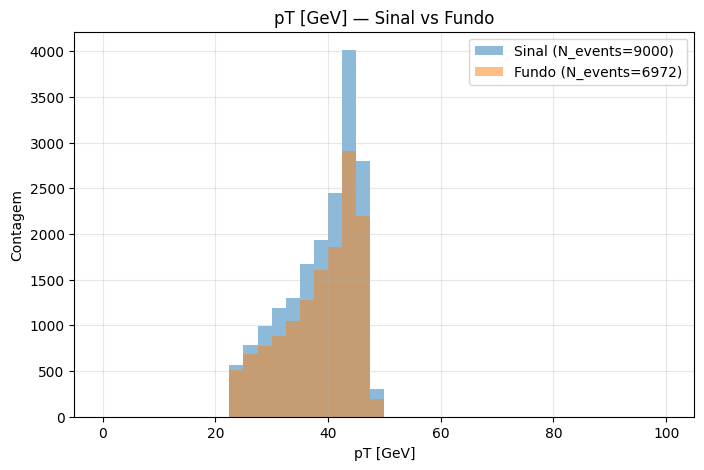

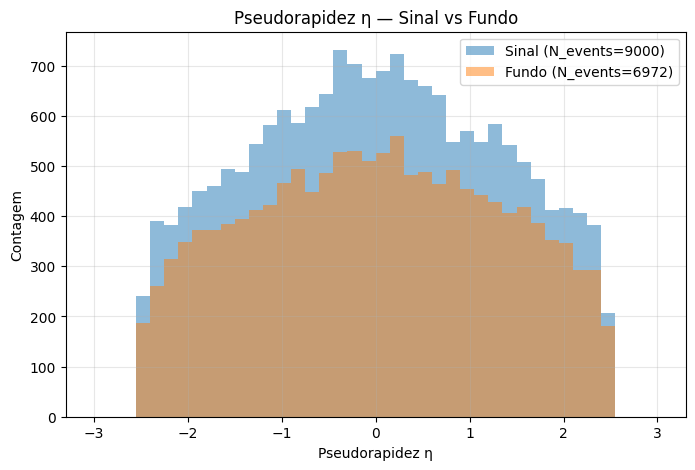

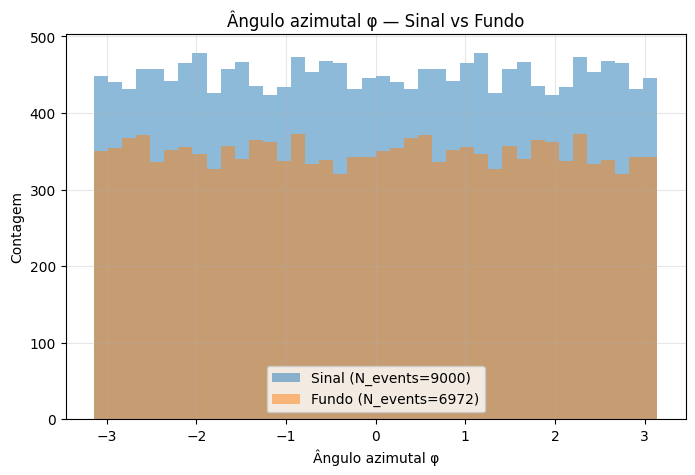

In [8]:
# -----------------------------------------
# FILTRAGEM para 23 < pT < 55 GeV -> Pelo histograma geral dá pra ver que é a região onde sinal>fundo
# -----------------------------------------

pt_min = 23
pt_max = 50

final_sinal_pt_window = final_sinal[(final_sinal["pt"] > pt_min) &
                                    (final_sinal["pt"] < pt_max)].copy()

final_fundo_pt_window = final_fundo[(final_fundo["pt"] > pt_min) &
                                    (final_fundo["pt"] < pt_max)].copy()

# Contagem de eventos únicos
eventos_sinal_window = final_sinal_pt_window["event_id"].nunique()
eventos_fundo_window = final_fundo_pt_window["event_id"].nunique()

print(f"=== Corte {pt_min} < pT < {pt_max} GeV ===")
print(f"Sinal: {len(final_sinal_pt_window)} partículas finais selecionadas")
print(f"Fundo: {len(final_fundo_pt_window)} partículas finais selecionadas")
print(f"Eventos únicos (sinal): {eventos_sinal_window}")
print(f"Eventos únicos (fundo): {eventos_fundo_window}")

# --- Histogramas solicitados ---
# pT de 0 a 100 GeV
plot_compare(final_sinal_pt_window, final_fundo_pt_window, eventos_sinal_window, eventos_fundo_window, "pt", "pT [GeV]", bins=40, xrng=(0,100))

# pseudorapidez η de -3 a +3
plot_compare(final_sinal_pt_window, final_fundo_pt_window, eventos_sinal_window, eventos_fundo_window, "eta", "Pseudorapidez η", bins=40, xrng=(-3,3))

# ângulo azimutal φ de -π a +π
plot_compare(final_sinal_pt_window, final_fundo_pt_window, eventos_sinal_window, eventos_fundo_window, "phi", "Ângulo azimutal φ", bins=40, xrng=(-np.pi, np.pi))




In [14]:
# --- [5] CONSERVAÇÃO DE ENERGIA ---
# Cálculo da variável de Mandelstam "s" por evento
# Usando apenas partículas com status == 1 e excluindo neutrinos


# Função para calcular "s" de um evento
def mandelstam_s(df_event):
    # Soma do quadrimomento total: (E, px, py, pz)
    E  = df_event["E"].sum()
    px = df_event["px"].sum()
    py = df_event["py"].sum()
    pz = df_event["pz"].sum()

    # s = (ΣE)^2 - |Σp⃗|^2
    s = E**2 - (px**2 + py**2 + pz**2)
    return s


# Eventos a serem impressos: event_id = 1 + 1000*i
eventos_alvo = [1 + 1000*i for i in range(10)]

print("=== Variável de Mandelstam s para eventos selecionados ===")
for ev in eventos_alvo:
    df_ev = final_sinal[final_sinal["event_id"] == ev]

    if len(df_ev) == 0:
        print(f"Evento {ev}: não encontrado no arquivo de sinal.")
        continue

    s_val = mandelstam_s(df_ev)
    print(f"Evento {ev}: s = {s_val:.6f} GeV²")


=== Variável de Mandelstam s para eventos selecionados ===
Evento 1: s = 5586.498721 GeV²
Evento 1001: s = 8321.587705 GeV²
Evento 2001: s = 8216.836446 GeV²
Evento 3001: s = 8144.985535 GeV²
Evento 4001: s = 8065.427564 GeV²
Evento 5001: s = 8569.919395 GeV²
Evento 6001: s = 8453.816613 GeV²
Evento 7001: s = 7902.405696 GeV²
Evento 8001: s = 9427.777590 GeV²
Evento 9001: s = 11966.753831 GeV²


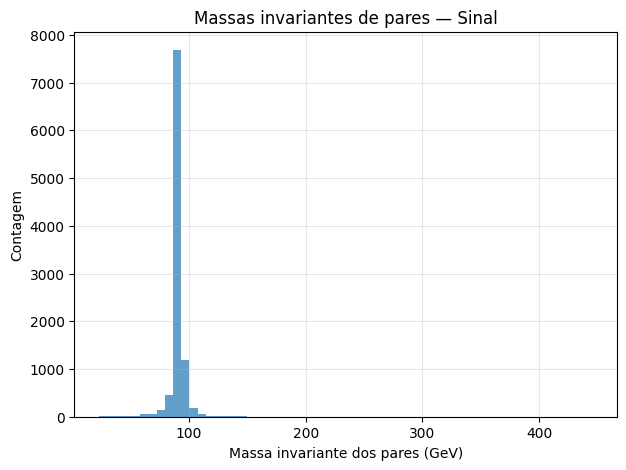

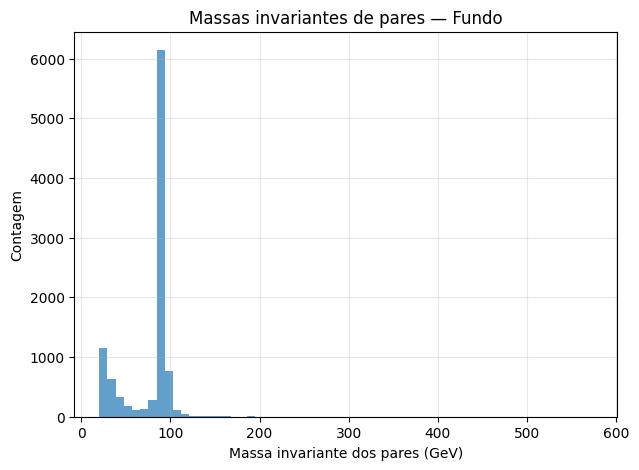

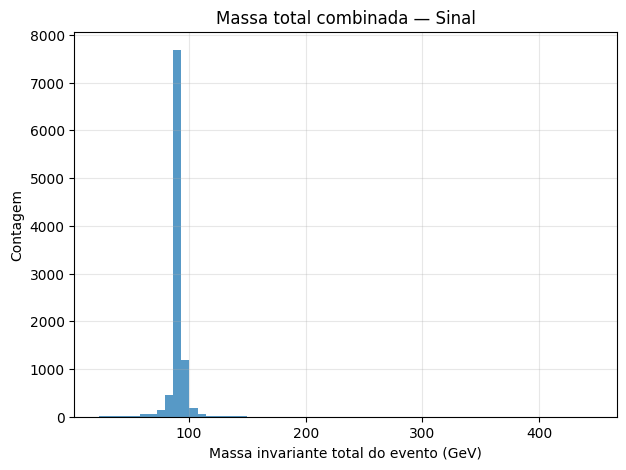

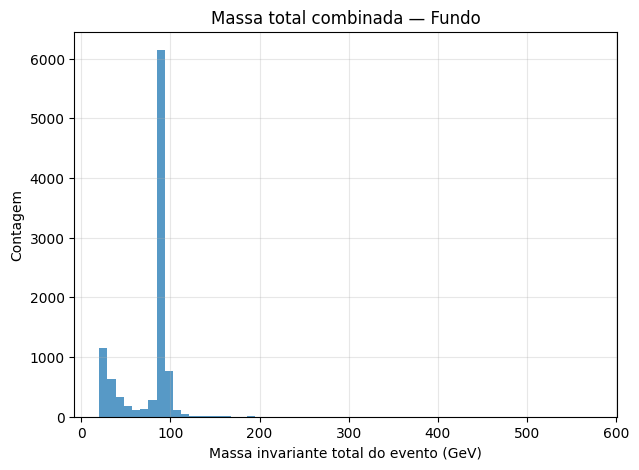

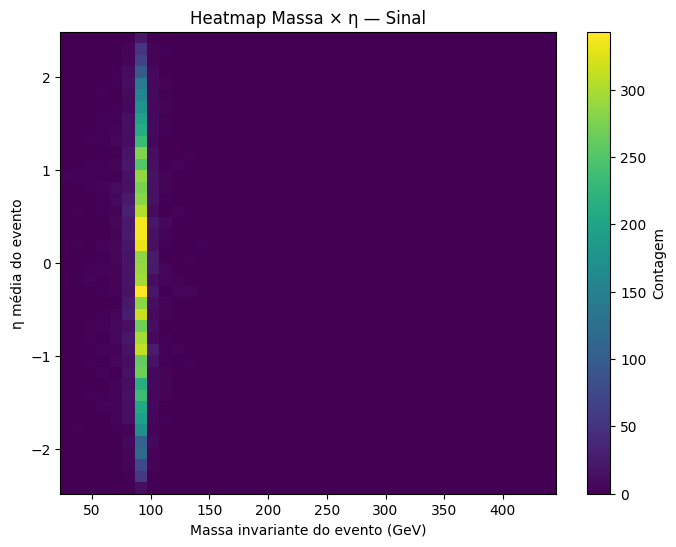

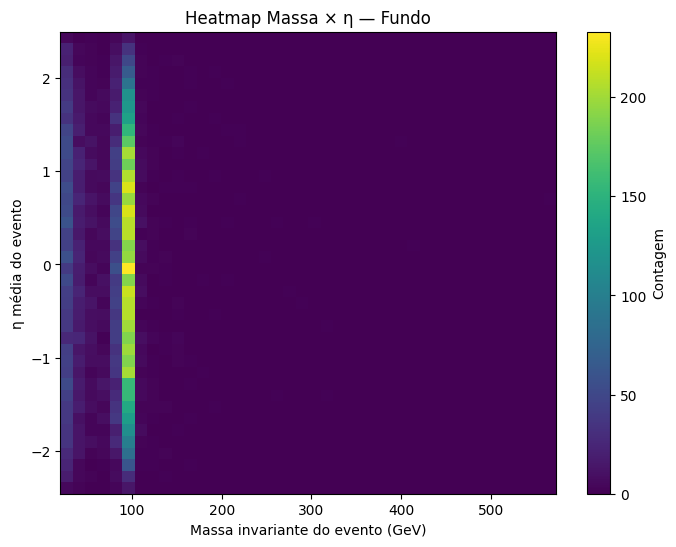

In [15]:
import itertools

# --- [6] RECONSTRUÇÃO DE VARIÁVEIS ---
# Massas invariantes de pares, massas combinadas e histogramas 2D


# Função: calcular massa invariante de dois ou mais quadrimomentos
def invariant_mass(df):
    E  = df["E"].sum()
    px = df["px"].sum()
    py = df["py"].sum()
    pz = df["pz"].sum()
    m2 = E**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(m2) if m2 > 0 else 0.0


# ============================
# 1. MASSA INVARIANTE DE PARES
# ============================

def mass_pairs(df_final, label="Sinal"):
    pares_massa = []
    tipos_pares = []

    for ev_id, df_ev in df_final.groupby("event_id"):
        # combinações de pares (i < j)
        indices = df_ev.index
        for i, j in itertools.combinations(indices, 2):
            p1 = df_ev.loc[[i]]
            p2 = df_ev.loc[[j]]
            m = invariant_mass(pd.concat([p1, p2]))
            pares_massa.append(m)
            tipos_pares.append((df_ev.loc[i, pdg_col], df_ev.loc[j, pdg_col]))

    plt.figure(figsize=(7,5))
    plt.hist(pares_massa, bins=60, alpha=0.7)
    plt.xlabel("Massa invariante dos pares (GeV)")
    plt.ylabel("Contagem")
    plt.title(f"Massas invariantes de pares — {label}")
    plt.grid(alpha=0.3)
    plt.show()

    return pares_massa, tipos_pares


#print("Plotando pares para o SINAL")
pares_sinal, tipos_sinal = mass_pairs(final_sinal, label="Sinal")

#print("Plotando pares para o FUNDO")
pares_fundo, tipos_fundo = mass_pairs(final_fundo, label="Fundo")

# =====================================================
# 2. MASSA INVARIANTE DE TODAS AS PARTÍCULAS DO EVENTO
# =====================================================

def mass_all_particles(df_final, label="Sinal"):
    massas = []
    for ev_id, df_ev in df_final.groupby("event_id"):
        M = invariant_mass(df_ev)
        massas.append(M)

    plt.figure(figsize=(7,5))
    plt.hist(massas, bins=60, alpha=0.75)
    plt.xlabel("Massa invariante total do evento (GeV)")
    plt.ylabel("Contagem")
    plt.title(f"Massa total combinada — {label}")
    plt.grid(alpha=0.3)
    plt.show()

    return massas

#print("Massa total — SINAL")
massas_sinal = mass_all_particles(final_sinal, label="Sinal")

#print("Massa total — FUNDO")
massas_fundo = mass_all_particles(final_fundo, label="Fundo")


# ============================================================
# 3. HEATMAP (2D) — MASSA INVARIANTE × pseudorapidez média η
# ============================================================

def mass_eta_2d(df_final, label="Sinal"):
    mass_list = []
    eta_list = []

    for ev_id, df_ev in df_final.groupby("event_id"):
        # massa total
        M = invariant_mass(df_ev)
        mass_list.append(M)

        # pseudorapidez média do evento
        eta_mean = df_ev["eta"].mean()
        eta_list.append(eta_mean)

    plt.figure(figsize=(8,6))
    plt.hist2d(mass_list, eta_list, bins=40)
    plt.xlabel("Massa invariante do evento (GeV)")
    plt.ylabel("η média do evento")
    plt.title(f"Heatmap Massa × η — {label}")
    plt.colorbar(label="Contagem")
    plt.show()


#print("Heatmap para SINAL")
mass_eta_2d(final_sinal, label="Sinal")

#print("Heatmap para FUNDO")
mass_eta_2d(final_fundo, label="Fundo")


In [17]:
import requests
import gzip
import os

# -----------------------------------------------------
# Extrair seção de choque de um arquivo .lhe.gz
# -----------------------------------------------------
def extrair_cross_section_lhe_gz(nome_arquivo):
    with gzip.open(nome_arquivo, "rt") as f:
        inside_init = False
        header_lines_read = 0

        for line in f:
            # início do bloco <init>
            if "<init>" in line:
                inside_init = True
                header_lines_read = 0
                continue

            # fim do bloco <init>
            if "</init>" in line:
                break

            if inside_init:
                header_lines_read += 1

                # A segunda linha contém XSECUP
                # Formato: XSECUP  XERRUP  XMAXUP  LPRUP
                if header_lines_read == 2:
                    partes = line.split()
                    xsec = float(partes[0])  # XSECUP é o primeiro campo
                    return xsec

    return None


# =====================================================
# USO: BAIXAR E EXTRAIR SIGMA DO SINAL E FUNDO
# =====================================================


# nomes locais
arquivo_sinal = "/content/lucas-lucas/data/sinal.lhe.gz"
arquivo_fundo = "/content/lucas-lucas/data/fundo.lhe.gz"

# extração da seção de choque
sigma_sinal = extrair_cross_section_lhe_gz(arquivo_sinal)
sigma_fundo = extrair_cross_section_lhe_gz(arquivo_fundo)

print(f"σ (sinal) = {sigma_sinal} pb")
print(f"σ (fundo) = {sigma_fundo} pb")


σ (sinal) = 637.39 pb
σ (fundo) = 841.64 pb


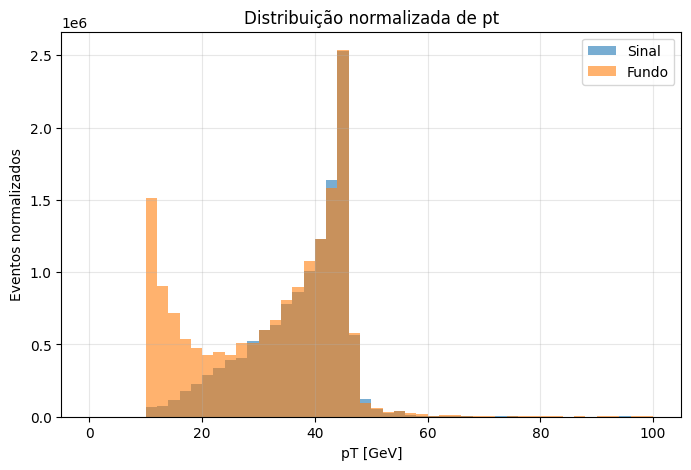

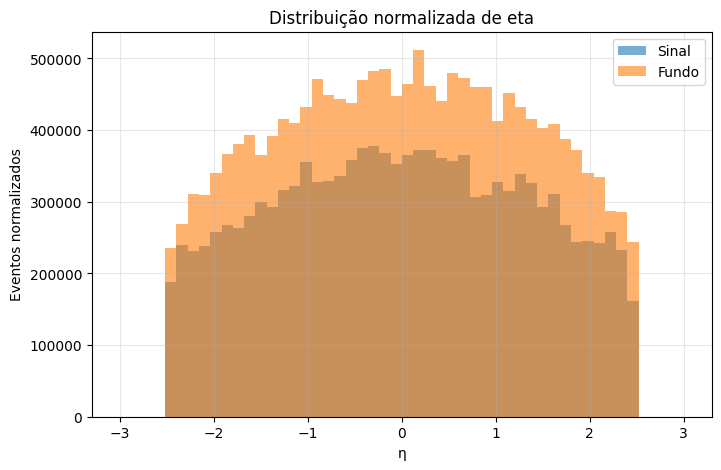

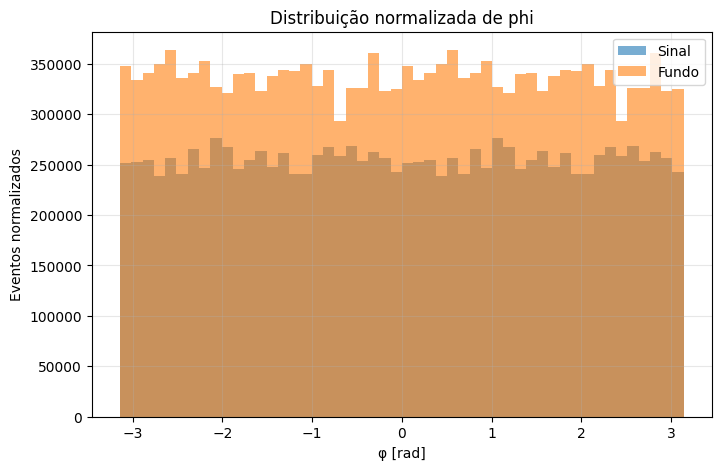

Eventos representados (sinal): 10000
Eventos representados (fundo): 10000


In [32]:
# --------------------------------------------------------------------
# Yield = N_eventos * (σ * L / N_total)
# Onde N_total é o número de eventos no .lhe
# (assumimos que N_total = len(sinal_df["event_id"].unique()))
# --------------------------------------------------------------------

L = 10000  # pb^-1  (10/fb)

N_sinal_total = sinal_df["event_id"].nunique()
N_fundo_total = fundo_df["event_id"].nunique()

w_sinal = (sigma_sinal * L) / N_sinal_total
w_fundo = (sigma_fundo * L) / N_fundo_total



vars_plot = {
    "pt": {"bins":50, "range":(0,100), "xlabel":"pT [GeV]"},
    "eta":{"bins":50, "range":(-3,3), "xlabel":"η"},
    "phi":{"bins":50, "range":(-np.pi, np.pi), "xlabel":"φ [rad]"}
}

for var, cfg in vars_plot.items():
    plt.figure(figsize=(8,5))

    plt.hist(final_sinal[var], bins=cfg["bins"], range=cfg["range"],
             weights=np.ones(len(final_sinal))*w_sinal, alpha=0.6, label="Sinal")

    plt.hist(final_fundo[var], bins=cfg["bins"], range=cfg["range"],
             weights=np.ones(len(final_fundo))*w_fundo, alpha=0.6, label="Fundo")

    plt.xlabel(cfg["xlabel"])
    plt.ylabel("Eventos normalizados")
    plt.title(f"Distribuição normalizada de {var}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

print("Eventos representados (sinal):", N_sinal_total)
print("Eventos representados (fundo):", N_fundo_total)





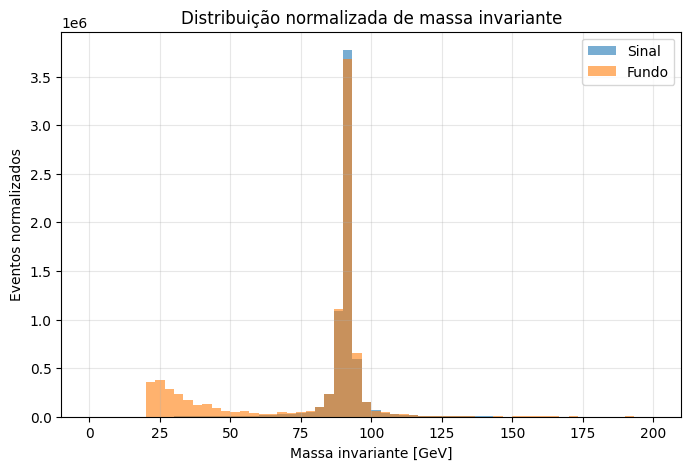

In [35]:
plt.figure(figsize=(8,5))

plt.hist(massas_sinal, bins=60, range=(0,200),
         weights=np.ones(len(massas_sinal))*w_sinal,
         alpha=0.6, label="Sinal")

plt.hist(massas_fundo, bins=60, range=(0,200),
         weights=np.ones(len(massas_fundo))*w_fundo,
         alpha=0.6, label="Fundo")

plt.xlabel("Massa invariante [GeV]")
plt.ylabel("Eventos normalizados")
plt.title("Distribuição normalizada de massa invariante")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


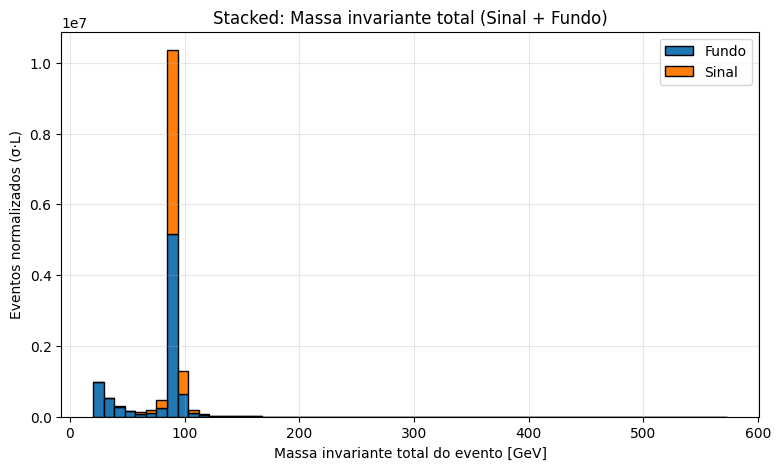

In [38]:
plt.figure(figsize=(9,5))

plt.hist(
    [massas_fundo, massas_sinal],
    bins=60,
    weights=[
        np.ones(len(massas_fundo)) * w_fundo,
        np.ones(len(massas_sinal)) * w_sinal
    ],
    stacked=True,
    label=["Fundo", "Sinal"],
    edgecolor="black"
)

plt.xlabel("Massa invariante total do evento [GeV]")
plt.ylabel("Eventos normalizados (σ·L)")
plt.title("Stacked: Massa invariante total (Sinal + Fundo)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Sim, faz sentido.
O n° de eventos esperado, considerando as seções de choque seriam:

N = 637.39*10000 = 6373900 (sinal)

N = 841.64*10000 = 8416400 (fundo)

Ou seja, o fundo deveria ser algo da ordem 1.32 vezes maior que o sinal, que o que se vê no penúltimo histograma (não stacked)

Observa-se um pico pronunciado nas proximidades de 100 GeV, que pode estar associado ao bóson Z, partícula mãe das partículas finais.